# Receive Renovar API Data

## Constants

### Sensors IDs

In [47]:
TEMPERATURE_ID     =  130
PRESSURE_ID        =  131
ALPHA_CO_ID        =  132
ALPHA_NO2_ID       =  133
ALPHA_SO2_1_ID     =  134
ALPHA_OX_1_ID      =  135
ALPHA_OX_2_ID      =  136
ALPHA_SO2_2_ID     =  137
EXT_TEMPERATURE_ID =  138
EXT_HUMIDITY_ID    =  139
PM10_ID            =  140
PM25_ID            =  141
PM01_ID            =  142
OPC_TEMPERATURE_ID =  143
OPC_HUMIDITY_ID    =  144

### API Constants

In [48]:
HOST = "renovar.lcqar.ufsc.br"
PORT = 8080
GET_SAMPLES_BY_SENSOR = "/sample/sensor/all/"
HTTP_REQUEST_MAIN = 'http://' + HOST + ':' + str(PORT) + GET_SAMPLES_BY_SENSOR

### Methods for creating and processing requests

In [49]:
import requests
import json
import pandas as pd
import numpy as np

class GetSensorDataService:
    def __init__(self, host, port, endpoint) -> None:
        self.__endpoint = 'http://' + host + ':' + str(port) + endpoint

    def get_json_data_from_sensor_id(self, id):
        return requests.get(self.__endpoint + str(id))

class SensorData:
    def __init__(self, sensor_id, sensor_name, lower_limit, upper_limit, t_90, t_90_value, sampling_period, get_service) -> None:
        self.__sensor_id = sensor_id
        self.__sensor_name = sensor_name
        self.__get_service = get_service
        self.__lower_limit = lower_limit
        self.__upper_limit = upper_limit
        self.__t_90 = t_90 / 2
        self.__t_90_value = t_90_value
        self.__sampling_period = sampling_period
        self.web_dataframe = []
        self.sensor_dataframe = []
        self.sensor_dataframe_1hr = []
        self.raw_series = []
        self.valid_series = []
        self.valid_differential_series = []

    def get_samples(self):
        response_json = self.__get_service.get_json_data_from_sensor_id(self.__sensor_id)
        response_dict = json.loads(response_json.content)
        response_dataframe = pd.DataFrame.from_dict(response_dict)
        response_dataframe['DateTime'] = (pd.to_datetime(response_dataframe['date'], 
                                        infer_datetime_format=False, 
                                        format='%d/%m/%Y %H:%M:%S'))
        self.web_dataframe = response_dataframe[["DateTime","measuring", "latitude", "longitude"]]

    def tag_and_prepare_data(self):
        self.sensor_dataframe = self.web_dataframe
        self.sensor_dataframe = ((self.sensor_dataframe.sort_values(by='DateTime', ascending=True)
                                  .reset_index().drop(columns='index')))
        self.sensor_dataframe.index = self.sensor_dataframe['DateTime']
        self.sensor_dataframe = self.sensor_dataframe.drop(columns=['DateTime'])
        
        # Create series
        self.sensor_dataframe = self.sensor_dataframe.resample('15T').mean()
        self.raw_series = self.sensor_dataframe['measuring']

        # Tag according to sensor limits
        self.sensor_dataframe['Tag'] = (self.sensor_dataframe['measuring']
                                        .apply(lambda v: self.__get_tags_from_series__(value=v,
                                                                                       lower_limit=self.__lower_limit,
                                                                                       upper_limit=self.__upper_limit)))
        
        # Calculate derivatives
        self.sensor_dataframe['Diff'] = self.sensor_dataframe['measuring'].resample('15T').mean().diff() 
        self.sensor_dataframe['Tag'] = (self.sensor_dataframe[['Tag', 'Diff']]
                                        .apply(lambda df: self.__tag_data_with_diff__(tagged_df=df), axis=1))
        self.valid_differential_series = self.sensor_dataframe[self.sensor_dataframe['Tag'] == 'VALID']['Diff']
        
        # Separate valid dataframe
        valid_dataframe = self.sensor_dataframe[self.sensor_dataframe['Tag'] == 'VALID']
        self.valid_series = valid_dataframe['measuring']
        
        # Calculate hourly statistics
        self.sensor_dataframe_1hr = self.__get_hour_statistics__(valid_dataframe, self.sensor_dataframe.index.freq)

    def __reset_index_to_date_time__(self, input_df):
        df = ((input_df.sort_values(by='DateTime', ascending=True)
               .reset_index().drop(columns='index')))
        df.index = input_df['DateTime']
        df = input_df.drop(columns=['DateTime'])
        return df
    
    def __get_tags_from_series__(self, value, lower_limit, upper_limit):
        if (value <= -9000.0  or 
            np.isnan(value))  : return 'MISSING' 
        if value < lower_limit: return 'LTLL'
        if value > upper_limit: return 'GTUL'
        return 'VALID'
    
    def __tag_data_with_diff__(self, tagged_df):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        max_diff_value = self.__sampling_period / self.__t_90 * self.__t_90_value
        if ((value > max_diff_value) or (value < -max_diff_value)): return 'BADSPIKE'
        return 'VALID'
    
    def __get_hour_statistics__(self, valid_dataframe, original_freq):
        resampled_dataframe = valid_dataframe.resample('H').mean()
        resampled_dataframe['Hour'] = resampled_dataframe.index.hour
        resampled_dataframe['Count'] = (valid_dataframe.resample('H').count()['measuring'])
        resampled_dataframe['Std'] = (valid_dataframe.resample('H').std()['measuring'])
        resampled_dataframe['% valid'] = (resampled_dataframe['Count']
                                          .map(lambda c:
                                               c / (pd.Timedelta("1 hour") / original_freq) * 100))
        resampled_dataframe['Tag'] = (resampled_dataframe['% valid']
                                        .map(lambda c: 'VALID' if c >= 75 else 'LOWSAMPLES'))
        return resampled_dataframe

    def calculate_and_tag_quantiles(self):
        dataframe = self.sensor_dataframe_1hr[self.sensor_dataframe_1hr['Tag'] == 'VALID']
        global_qtle_01 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
        global_qtle_99 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
        self.sensor_dataframe_1hr['GLOBAL_QTLE01'] = self.sensor_dataframe_1hr['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
        self.sensor_dataframe_1hr['GLOBAL_QTLE99'] = self.sensor_dataframe_1hr['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
        self.sensor_dataframe_1hr['Tag'] = (self.sensor_dataframe_1hr[['Tag', 'measuring', 'GLOBAL_QTLE01', 'GLOBAL_QTLE99']]
                                            .apply(lambda df: self.__tag_by_quantiles__(tagged_df=df), axis=1))

    def __tag_by_quantiles__(self, tagged_df):
        current_tag = tagged_df[0]
        value = tagged_df[1]
        quantile_01 = tagged_df[2]
        quantile_99 = tagged_df[3]
        if ((current_tag != 'VALID') or (np.isnan(value))): return current_tag
        if value <= quantile_01: return 'LTQTLE01'
        if value >= quantile_99: return 'GTQTLE99'
        return 'VALID'

    def save_to_csv(self):
        self.web_dataframe.to_csv(self.__sensor_name + 'web_dataframe.csv')

    def read_from_csv(self):
        df = pd.read_csv(self.__sensor_name + 'web_dataframe.csv')
        self.web_dataframe = df.drop(df.columns[0], axis='columns')
        self.web_dataframe['DateTime'] = (pd.to_datetime(df['DateTime'], infer_datetime_format=True))

In [50]:
get_sensor_data_service = GetSensorDataService(HOST, PORT, GET_SAMPLES_BY_SENSOR)

In [51]:
def count_tags(tags_list, df):
  tags_list.append('TOTAL')
  count = len(df)
  data_count = pd.DataFrame(index=tags_list, columns=['#', '%'])
  data_count.loc['TOTAL'] = [count, (count/count)*100]

  for tag in data_count.index[:-1]:
    val = (df.where(df['Tag'] == tag)
              .count()['Tag'])  # Fiz assim pq count() não conta os nan
    data_count.loc[tag] = [val, (val/count)*100]

  return data_count

In [52]:
# alpha_pm_10_conc_data   = SensorData(PM10_ID, sensor_name='alha_pm_10_conc', lower_limit=0.0, upper_limit=1e6, get_service=get_sensor_data_service)
# alpha_pm_2_5_conc_data  = SensorData(PM25_ID, sensor_name='alha_pm_2_5_conc',lower_limit=0.0, upper_limit=1e6, get_service=get_sensor_data_service)
# alpha_pm_1_conc_data    = SensorData(PM01_ID, sensor_name='alha_pm_1_conc',  lower_limit=0.0, upper_limit=1e6, get_service=get_sensor_data_service)

# Alphasense SO2 Sensor Data

In [53]:
alpha_so21_conc_data = SensorData(ALPHA_SO2_1_ID, sensor_name='alha_so2_1_conc', lower_limit=5.0, upper_limit=2e3, 
                                t_90=60, t_90_value=2e3, sampling_period=15 * 60, 
                                get_service=get_sensor_data_service)

alpha_so22_conc_data = SensorData(ALPHA_SO2_1_ID, sensor_name='alha_so2_2_conc', lower_limit=5.0, upper_limit=2e3, 
                                t_90=60, t_90_value=2e3, sampling_period=15 * 60, 
                                get_service=get_sensor_data_service)

## Upload Data from File

In [54]:
alpha_so21_conc_data.read_from_csv()
alpha_so21_conc_data.web_dataframe.head()

,DateTime,measuring,latitude,longitude
0,2022-11-21 10:38:50,84.0,-28.4569,-48.973
1,2022-11-21 11:10:24,96.0,-28.4569,-48.973
2,2022-11-21 11:41:56,79.0,-28.4569,-48.973
3,2022-11-21 12:13:28,61.0,-28.4569,-48.973
4,2022-11-21 13:47:57,63.0,-28.4569,-48.973


In [55]:
alpha_so22_conc_data.read_from_csv()
alpha_so22_conc_data.web_dataframe.head()

,DateTime,measuring,latitude,longitude
0,2022-11-21 10:42:00,92.0,-28.4569,-48.973
1,2022-11-21 11:13:35,70.0,-28.4569,-48.973
2,2022-11-21 11:45:05,67.0,-28.4569,-48.973
3,2022-11-21 12:00:50,71.0,-28.4569,-48.973
4,2022-11-21 15:41:22,92.0,-28.4569,-48.973


## Tag data

In [56]:
alpha_so21_conc_data.tag_and_prepare_data()
alpha_so21_conc_data.sensor_dataframe.head()

,measuring,latitude,longitude,Tag,Diff
DateTime,,,,,
2022-11-21 10:30:00,84.0,-28.4569,-48.973,VALID,NaN
2022-11-21 10:45:00,NaN,NaN,NaN,MISSING,NaN
2022-11-21 11:00:00,96.0,-28.4569,-48.973,VALID,NaN
2022-11-21 11:15:00,NaN,NaN,NaN,MISSING,NaN
2022-11-21 11:30:00,79.0,-28.4569,-48.973,VALID,NaN


In [57]:
alpha_so22_conc_data.tag_and_prepare_data()
alpha_so22_conc_data.sensor_dataframe.head()

,measuring,latitude,longitude,Tag,Diff
DateTime,,,,,
2022-11-21 10:30:00,92.0,-28.4569,-48.973,VALID,NaN
2022-11-21 10:45:00,NaN,NaN,NaN,MISSING,NaN
2022-11-21 11:00:00,70.0,-28.4569,-48.973,VALID,NaN
2022-11-21 11:15:00,NaN,NaN,NaN,MISSING,NaN
2022-11-21 11:30:00,NaN,NaN,NaN,MISSING,NaN


### Data Tag contabilization

In [58]:
data_contabilization = count_tags(['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID'], alpha_so21_conc_data.sensor_dataframe)
data_contabilization

,#,%
MISSING,9365,53.3193
LTLL,1039,5.91551
GTUL,2056,11.7058
BADSPIKE,0,0
VALID,5104,29.0594
TOTAL,17564,100


In [59]:
data_contabilization = count_tags(['MISSING','LTLL', 'GTUL', 'BADSPIKE', 'VALID'], alpha_so22_conc_data.sensor_dataframe)
data_contabilization

,#,%
MISSING,6358,43.7216
LTLL,1660,11.4152
GTUL,784,5.39128
BADSPIKE,0,0
VALID,5740,39.4719
TOTAL,14542,100


### Plot raw data

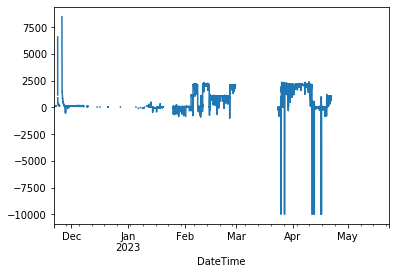

In [60]:
alpha_so21_conc_data.sensor_dataframe['measuring'].plot()

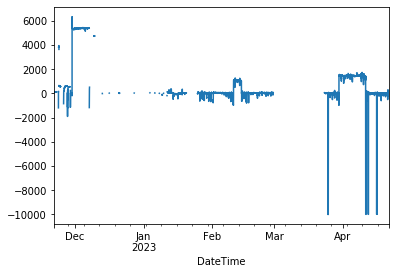

In [61]:
alpha_so22_conc_data.sensor_dataframe['measuring'].plot()

### Plot Valid Data

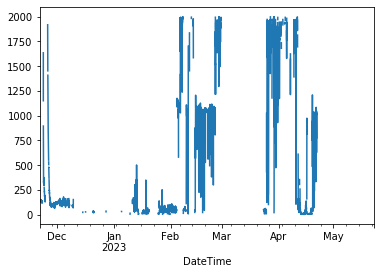

In [62]:
alpha_so21_conc_data.sensor_dataframe[alpha_so21_conc_data.sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()

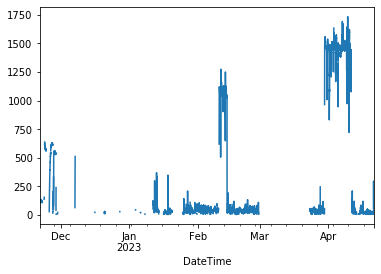

In [63]:
alpha_so22_conc_data.sensor_dataframe[alpha_so22_conc_data.sensor_dataframe['Tag'] == 'VALID']['measuring'].resample('15T').mean().plot()

### Plot raw derivatives

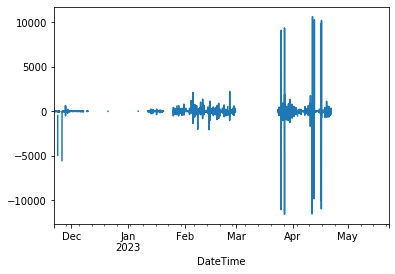

In [64]:
alpha_so21_conc_data.sensor_dataframe['Diff'].resample('15T').mean().plot()

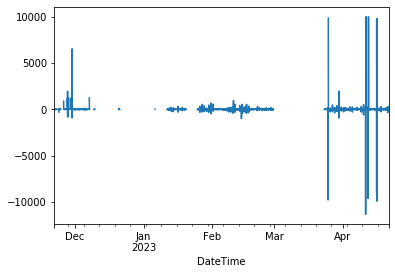

In [65]:
alpha_so22_conc_data.sensor_dataframe['Diff'].resample('15T').mean().plot()

### Plot valid derivatives

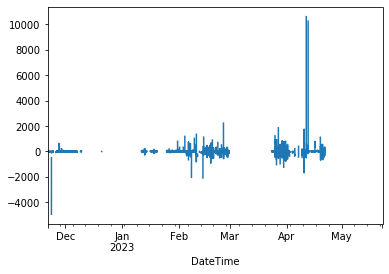

In [66]:
alpha_so21_conc_data.valid_differential_series.resample('15T').mean().plot()

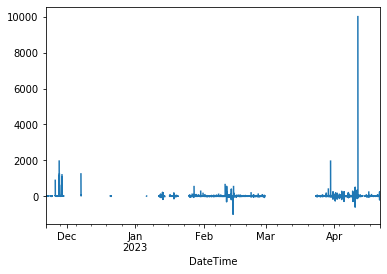

In [67]:
alpha_so22_conc_data.valid_differential_series.resample('15T').mean().plot()

## Resampled data

In [68]:
alpha_so21_conc_data.sensor_dataframe_1hr.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,Tag
DateTime,,,,,,,,,
2022-11-21 10:00:00,84.0,-28.4569,-48.973,NaN,10,1,NaN,25.0,LOWSAMPLES
2022-11-21 11:00:00,87.5,-28.4569,-48.973,NaN,11,2,12.020815,50.0,LOWSAMPLES
2022-11-21 12:00:00,61.0,-28.4569,-48.973,NaN,12,1,NaN,25.0,LOWSAMPLES
2022-11-21 13:00:00,63.0,-28.4569,-48.973,NaN,13,1,NaN,25.0,LOWSAMPLES
2022-11-21 14:00:00,NaN,NaN,NaN,NaN,14,0,NaN,0.0,LOWSAMPLES


In [69]:
alpha_so22_conc_data.sensor_dataframe_1hr.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,Tag
DateTime,,,,,,,,,
2022-11-21 10:00:00,92.0,-28.4569,-48.973,NaN,10,1,NaN,25.0,LOWSAMPLES
2022-11-21 11:00:00,68.5,-28.4569,-48.973,NaN,11,2,2.12132,50.0,LOWSAMPLES
2022-11-21 12:00:00,71.0,-28.4569,-48.973,4.0,12,1,NaN,25.0,LOWSAMPLES
2022-11-21 13:00:00,NaN,NaN,NaN,NaN,13,0,NaN,0.0,LOWSAMPLES
2022-11-21 14:00:00,NaN,NaN,NaN,NaN,14,0,NaN,0.0,LOWSAMPLES


### Data contabilization

In [70]:
data_contabilization = count_tags(['LOWSAMPLES','VALID'], alpha_so21_conc_data.sensor_dataframe_1hr)
data_contabilization

,#,%
LOWSAMPLES,3179,72.3816
VALID,1213,27.6184
TOTAL,4392,100


In [71]:
data_contabilization = count_tags(['LOWSAMPLES','VALID'], alpha_so22_conc_data.sensor_dataframe_1hr)
data_contabilization

,#,%
LOWSAMPLES,2243,61.6887
VALID,1393,38.3113
TOTAL,3636,100


### Plot raw hourly data

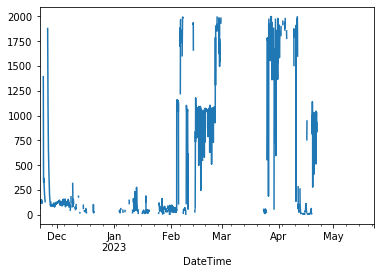

In [72]:
alpha_so21_conc_data.sensor_dataframe_1hr['measuring'].plot()

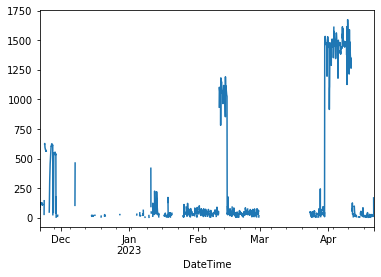

In [73]:
alpha_so22_conc_data.sensor_dataframe_1hr['measuring'].plot()

### Plot valid hourly data

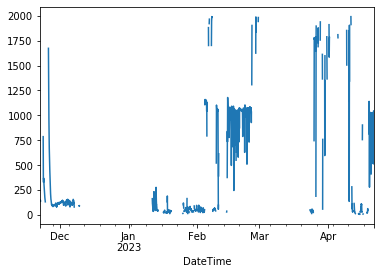

In [74]:
alpha_so21_conc_data.sensor_dataframe_1hr[alpha_so21_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

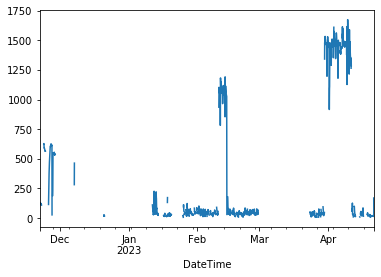

In [75]:
alpha_so22_conc_data.sensor_dataframe_1hr[alpha_so22_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['measuring'].resample('H').mean().plot()

### Plot raw standard deviation

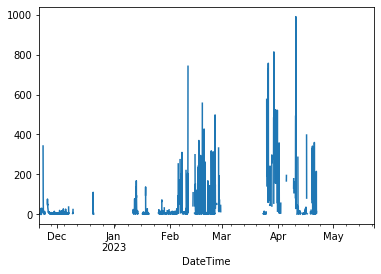

In [76]:
alpha_so21_conc_data.sensor_dataframe_1hr['Std'].resample('H').mean().plot()

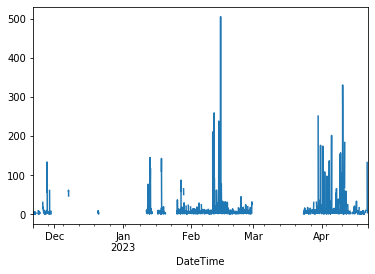

In [77]:
alpha_so22_conc_data.sensor_dataframe_1hr['Std'].resample('H').mean().plot()

### Plot valid standard deviation

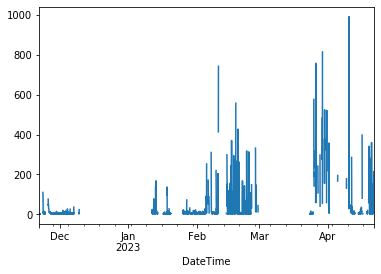

In [78]:
alpha_so21_conc_data.sensor_dataframe_1hr[alpha_so21_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['Std'].resample('H').mean().plot()

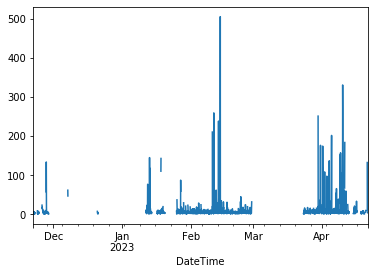

In [79]:
alpha_so22_conc_data.sensor_dataframe_1hr[alpha_so22_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID']['Std'].resample('H').mean().plot()

## Calculate quantiles and tag data accordingly

### Calculate quantiles

In [80]:
alpha_so21_conc_data.calculate_and_tag_quantiles()
alpha_so21_conc_data.sensor_dataframe_1hr.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,Tag,GLOBAL_QTLE01,GLOBAL_QTLE99
DateTime,,,,,,,,,,,
2022-11-21 10:00:00,84.0,-28.4569,-48.973,NaN,10,1,NaN,25.0,LOWSAMPLES,32.000000,1986.666667
2022-11-21 11:00:00,87.5,-28.4569,-48.973,NaN,11,2,12.020815,50.0,LOWSAMPLES,37.750000,1966.333333
2022-11-21 12:00:00,61.0,-28.4569,-48.973,NaN,12,1,NaN,25.0,LOWSAMPLES,15.000000,1971.000000
2022-11-21 13:00:00,63.0,-28.4569,-48.973,NaN,13,1,NaN,25.0,LOWSAMPLES,16.000000,1986.000000
2022-11-21 14:00:00,NaN,NaN,NaN,NaN,14,0,NaN,0.0,LOWSAMPLES,14.666667,1990.500000


In [81]:
alpha_so22_conc_data.calculate_and_tag_quantiles()
alpha_so22_conc_data.sensor_dataframe_1hr.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,Tag,GLOBAL_QTLE01,GLOBAL_QTLE99
DateTime,,,,,,,,,,,
2022-11-21 10:00:00,92.0,-28.4569,-48.973,NaN,10,1,NaN,25.0,LOWSAMPLES,13.333333,1614.00
2022-11-21 11:00:00,68.5,-28.4569,-48.973,NaN,11,2,2.12132,50.0,LOWSAMPLES,8.666667,1560.75
2022-11-21 12:00:00,71.0,-28.4569,-48.973,4.0,12,1,NaN,25.0,LOWSAMPLES,8.000000,1555.75
2022-11-21 13:00:00,NaN,NaN,NaN,NaN,13,0,NaN,0.0,LOWSAMPLES,16.000000,1609.50
2022-11-21 14:00:00,NaN,NaN,NaN,NaN,14,0,NaN,0.0,LOWSAMPLES,8.333333,1588.75


## Process valid hourly data

### Methods definitions

In [82]:
import matplotlib.pyplot as plt

def plot_mean_vs_std(df):
    fig = plt.figure(figsize=(1.3*7,7))
    plt.scatter(df['Std'], df['measuring'], c=df['% valid'], cmap='jet')
    cax = plt.axes([0.95, 0.1, 0.05
                    , 0.8])
    cbar = plt.colorbar(orientation='vertical', cax=cax)
    cbar.ax.tick_params(labelsize=11, length=0)
    ticks = [np.int64(df['% valid'].min() + 1), 
             np.int64((df['% valid'].max() - df['% valid'].min()) / 2),
             np.int64(df['% valid'].max())]
    cbar.set_ticks(np.array(ticks))
    cbar.ax.tick_params(labelsize=15, length=0)

def plot_std_in_time(df):
    fig = plt.figure(figsize=(1.3*7,7))
    plt.scatter(df.index, df['Std'], c=df['% valid'], cmap='jet')
    cax = plt.axes([0.95, 0.1, 0.05, 0.8])
    cbar = plt.colorbar(orientation='vertical', cax=cax)
    cbar.ax.tick_params(labelsize=11, length=0)
    ticks = [np.int64(df['% valid'].min() + 1),
             np.int64((df['% valid'].max() - df['% valid'].min()) / 2),
             np.int64(df['% valid'].max())]
    cbar.set_ticks(np.array(ticks))
    cbar.ax.tick_params(labelsize=15, length=0)

def plot_box_hist(df, bins):
  bottom, height = 0.1, 0.65
  left, width = bottom, height*1.3
  spacing = 0.005
  
  rect_ser = [left-width-spacing, bottom, width, height]
  rect_box = [left, bottom, width, height]
  rect_hist = [left + width + spacing, bottom, height/1.3, height]

  plt.figure(figsize=(5, 5/1.3))

  ax_ser  = plt.axes(rect_ser)
  ax_ser.tick_params(direction='in', top=True, right=True)
  ax_ser.set_title('Serie temporal')

  ax_box  = plt.axes(rect_box)
  ax_box.tick_params(direction='in', labelleft=False)

  ax_hist = plt.axes(rect_hist)
  ax_hist.tick_params(direction='in', labelleft=False)
  ax_hist.set_title('Histograma')

  lim_max = df['measuring'].max()+df['measuring'].max()*10/100
  lim_min = df['measuring'].min()-df['measuring'].min()*10/100

  df['measuring'].plot(ax=ax_ser)
  ax_ser.set_ylim(lim_min, lim_max)

  ax_hist.hist(df['measuring'], bins=bins, orientation='horizontal')
  ax_hist.set_ylim(lim_min, lim_max)

  df = df.dropna(axis='index', how='all', subset=['Hour'])
  df['Hour'] = df['Hour'].astype('int64')
  df.pivot(columns='Hour')['measuring'].dropna(
        axis='columns', how='all').plot.box(
            ax=ax_box,title='Comportamento médio no período')
  ax_box.set_ylim(ax_hist.get_ylim())

In [83]:
dataframe = alpha_so21_conc_data.sensor_dataframe_1hr[alpha_so21_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID'].resample('H').mean()
dataframe1 = alpha_so22_conc_data.sensor_dataframe_1hr[alpha_so22_conc_data.sensor_dataframe_1hr['Tag'] == 'VALID'].resample('H').mean()

## Calculate quantiles

In [84]:
global_qtle_01 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = dataframe.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
dataframe['GLOBAL QTLE01'] = dataframe['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
dataframe['GLOBAL QTLE99'] = dataframe['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
dataframe.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,GLOBAL_QTLE01,GLOBAL_QTLE99,GLOBAL QTLE01,GLOBAL QTLE99
DateTime,,,,,,,,,,,,
2022-11-21 21:00:00,133.500000,-28.4569,-48.973,-0.50,21.0,4.0,4.434712,100.0,6.333333,1673.500000,13.666667,1547.75
2022-11-21 22:00:00,135.750000,-28.4569,-48.973,0.00,22.0,4.0,2.872281,100.0,14.250000,1498.000000,23.750000,1149.25
2022-11-21 23:00:00,139.666667,-28.4569,-48.973,-3.00,23.0,3.0,4.725816,75.0,10.250000,1349.750000,24.500000,1137.50
2022-11-22 00:00:00,146.250000,-28.4569,-48.973,3.25,0.0,4.0,3.201562,100.0,21.500000,1210.000000,29.750000,1138.50
2022-11-22 01:00:00,142.250000,-28.4569,-48.973,-0.75,1.0,4.0,2.986079,100.0,7.500000,1881.333333,21.500000,1144.00


In [85]:
global_qtle_01 = dataframe1.pivot(columns='Hour')['measuring'].quantile(q=0.01, axis='index', interpolation='lower').dropna()
global_qtle_99 = dataframe1.pivot(columns='Hour')['measuring'].quantile(q=0.99, axis='index', interpolation='higher').dropna()
dataframe1['GLOBAL QTLE01'] = dataframe1['Hour'].map(lambda hr: global_qtle_01[hr] if (not np.isnan(hr)) else np.nan)
dataframe1['GLOBAL QTLE99'] = dataframe1['Hour'].map(lambda hr: global_qtle_99[hr] if (not np.isnan(hr)) else np.nan)
dataframe1.head()

,measuring,latitude,longitude,Diff,Hour,Count,Std,% valid,GLOBAL_QTLE01,GLOBAL_QTLE99,GLOBAL QTLE01,GLOBAL QTLE99
DateTime,,,,,,,,,,,,
2022-11-21 19:00:00,123.666667,-28.4569,-48.973,6.00,19.0,3.0,5.033223,75.0,10.000000,1673.75,10.750000,1524.000000
2022-11-21 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-11-21 21:00:00,120.000000,-28.4569,-48.973,2.25,21.0,4.0,6.055301,100.0,7.666667,1490.75,10.333333,1490.250000
2022-11-21 22:00:00,122.333333,-28.4569,-48.973,-3.00,22.0,3.0,0.577350,75.0,10.000000,1488.00,12.250000,1487.666667
2022-11-21 23:00:00,126.000000,-28.4569,-48.973,3.25,23.0,4.0,6.164414,100.0,16.500000,1489.00,18.000000,1481.000000


### Plot mean vs. standard deviation for valid hourly data colored by valid percentage of valid samples

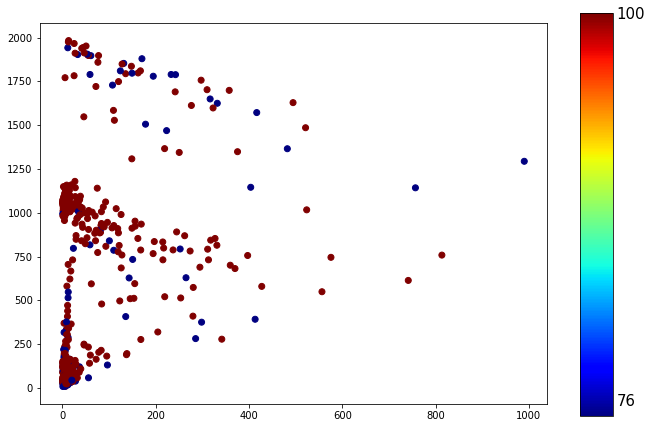

In [86]:
plot_mean_vs_std(dataframe)

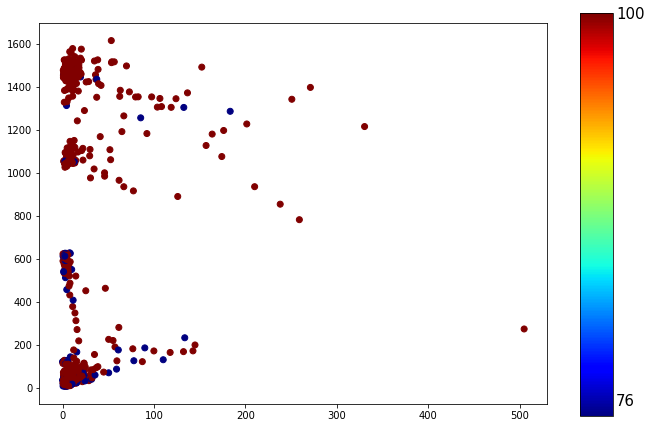

In [87]:
plot_mean_vs_std(dataframe1)

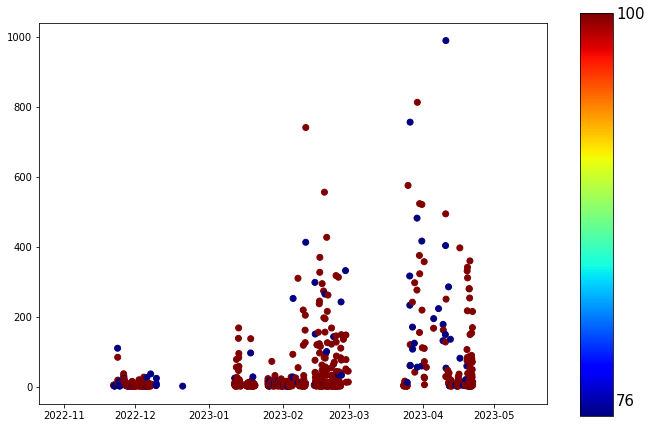

In [88]:
plot_std_in_time(dataframe)

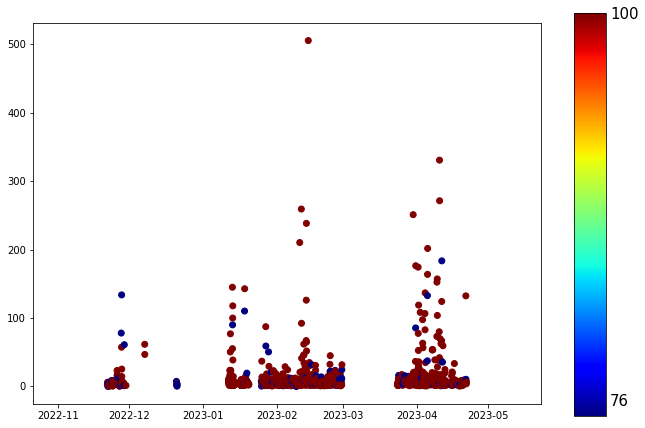

In [89]:
plot_std_in_time(dataframe1)

c:\Users\Fernando\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\Fernando\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
c:\Users\Fernando\anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


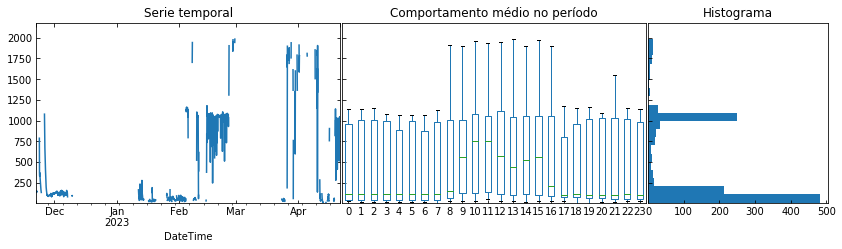

In [90]:
plot_box_hist(dataframe, 20)

c:\Users\Fernando\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\Fernando\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
c:\Users\Fernando\anaconda3\lib\site-packages\ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


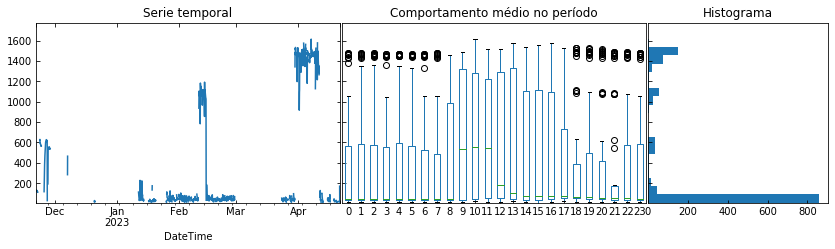

In [91]:
plot_box_hist(dataframe1, 20)